In [ ]:
import numpy as np
import open3d as o3d
import copy
import os
from scipy.stats import ortho_group

# Function to load point clouds
def load_point_cloud(file_path):
    pcd = o3d.io.read_point_cloud(file_path)
    return pcd

# Function to visualize point clouds
def visualize_point_clouds(source, target, source_transformed=None):
    vis_list = []
    
    # Original source in red
    source_temp = copy.deepcopy(source)
    source_temp.paint_uniform_color([1, 0, 0])  # Red for source
    vis_list.append(source_temp)
    
    # Target in green
    target_temp = copy.deepcopy(target)
    target_temp.paint_uniform_color([0, 1, 0])  # Green for target
    vis_list.append(target_temp)
    
    # Transformed source in blue (if provided)
    if source_transformed is not None:
        source_transformed_temp = copy.deepcopy(source_transformed)
        source_transformed_temp.paint_uniform_color([0, 0, 1])  # Blue for transformed source
        vis_list.append(source_transformed_temp)
    
    o3d.visualization.draw_geometries(vis_list)

# Function to run ICP
def point_to_point_icp(source, target, initial_transform=None, max_iteration=30, threshold=0.02):
    if initial_transform is None:
        # Create a valid initial transformation matrix with rotation and translation
        # Using scipy's ortho_group to generate a random orthonormal matrix for rotation
        R = ortho_group.rvs(3)
        t = np.random.rand(3, 1) * 0.5  # Small random translation
        
        initial_transform = np.eye(4)
        initial_transform[:3, :3] = R
        initial_transform[:3, 3:] = t
    
    # Evaluate initial alignment
    evaluation = o3d.pipelines.registration.evaluate_registration(
        source, target, threshold, initial_transform)
    initial_fitness = evaluation.fitness
    initial_rmse = evaluation.inlier_rmse
    
    print(f"Initial alignment - Fitness: {initial_fitness}, RMSE: {initial_rmse}")
    
    # Run ICP
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, target, threshold, initial_transform,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=max_iteration))
    
    # Get results
    transformation = reg_p2p.transformation
    fitness = reg_p2p.fitness
    inlier_rmse = reg_p2p.inlier_rmse
    
    print(f"ICP registration - Fitness: {fitness}, RMSE: {inlier_rmse}")
    print(f"Transformation matrix:\n{transformation}")
    
    return transformation, initial_fitness, initial_rmse, fitness, inlier_rmse
# Now, let's use these functions to load two consecutive point clouds and perform ICP registration:
dataset_dir = f"C:/Users/aarya/Github_Projects/Striver_A2Z/cv_bonus/selected_pcds"  # Change this to your dataset path
 
# Get sorted list of point cloud files
pcd_files = sorted([f for f in os.listdir(dataset_dir) if f.startswith("pointcloud_") and f.endswith(".pcd")])

# Select two consecutive point clouds (e.g., the first two)
source_file = os.path.join(dataset_dir, pcd_files[0])
target_file = os.path.join(dataset_dir, pcd_files[1])

print(f"Source: {pcd_files[0]}")
print(f"Target: {pcd_files[1]}")

# Load point clouds
source = load_point_cloud(source_file)
target = load_point_cloud(target_file)

# Print basic information about the point clouds
print(f"Source point cloud has {len(source.points)} points")
print(f"Target point cloud has {len(target.points)} points")

# Visualize original point clouds
print("Visualizing original point clouds (red: source, green: target)")
visualize_point_clouds(source, target)

# Generate initial transformation and run ICP
transformation, initial_fitness, initial_rmse, final_fitness, final_rmse = point_to_point_icp(source, target)

# Transform the source point cloud using the estimated transformation
source_transformed = copy.deepcopy(source)
source_transformed.transform(transformation)

# Visualize the result
print("Visualizing point clouds after ICP (red: original source, green: target, blue: transformed source)")
visualize_point_clouds(source, target, source_transformed)

# Report results
print("\nPoint-to-Point ICP Results:")
print(f"Initial alignment - Fitness: {initial_fitness:.6f}, RMSE: {initial_rmse:.6f}")
print(f"Final alignment - Fitness: {final_fitness:.6f}, RMSE: {final_rmse:.6f}")
print(f"Improvement - Fitness: {final_fitness - initial_fitness:.6f}, RMSE: {initial_rmse - final_rmse:.6f}")

# Now, let's extend the code to register multiple point clouds and reconstruct the TurtleBot's trajectory:
def register_point_cloud_sequence(pcd_files, dataset_dir, max_iteration=30, threshold=0.02):
    """
    Register a sequence of point clouds and compute the trajectory
    """
    # List to store trajectory (poses)
    trajectory = []
    
    # List to store registered point clouds
    registered_pcds = []
    
    # Load the first point cloud
    first_pcd = load_point_cloud(os.path.join(dataset_dir, pcd_files[0]))
    
    # Add the first point cloud to the list of registered point clouds
    registered_pcds.append(copy.deepcopy(first_pcd))
    
    # Add the identity matrix as the first pose (global frame is set to the first point cloud)
    trajectory.append(np.eye(4))
    
    # Global transformation (accumulated)
    global_transform = np.eye(4)
    
    # Process each consecutive pair of point clouds
    for i in range(1, len(pcd_files)):
        print(f"\nProcessing point clouds {i-1} and {i}...")
        
        # Load the current point cloud
        current_pcd = load_point_cloud(os.path.join(dataset_dir, pcd_files[i]))
        
        # Previous registered point cloud
        prev_pcd = registered_pcds[-1]
        
        # Initial transformation (small perturbation around identity)
        R = ortho_group.rvs(3)  # Random rotation
        t = np.random.rand(3, 1) * 0.1  # Small random translation
        
        initial_transform = np.eye(4)
        initial_transform[:3, :3] = R
        initial_transform[:3, 3:] = t
        
        # Run ICP to find the transformation from current to previous
        transformation, _, _, fitness, rmse = point_to_point_icp(
            current_pcd, prev_pcd, initial_transform, max_iteration, threshold)
        
        # Update the global transformation
        global_transform = global_transform @ transformation
        
        # Add the global transformation to the trajectory
        trajectory.append(copy.deepcopy(global_transform))
        
        # Transform the current point cloud to the global frame
        transformed_pcd = copy.deepcopy(current_pcd)
        transformed_pcd.transform(global_transform)
        
        # Add the transformed point cloud to the list of registered point clouds
        registered_pcds.append(transformed_pcd)
        
        print(f"Registration {i}/{len(pcd_files)-1} - Fitness: {fitness:.6f}, RMSE: {rmse:.6f}")
    
    return registered_pcds, trajectory

# Function to visualize the trajectory
def visualize_trajectory(trajectory):
    """
    Visualize the trajectory as a line set
    """
    # Create a LineSet to represent the trajectory
    line_set = o3d.geometry.LineSet()
    
    # Extract the translation part of each transformation matrix
    points = np.array([T[:3, 3] for T in trajectory])
    
    # Set the points
    line_set.points = o3d.utility.Vector3dVector(points)
    
    # Create lines connecting consecutive points
    lines = [[i, i + 1] for i in range(len(points) - 1)]
    line_set.lines = o3d.utility.Vector2iVector(lines)
    
    # Set colors (red)
    colors = [[1, 0, 0] for _ in range(len(lines))]
    line_set.colors = o3d.utility.Vector3dVector(colors)
    
    return line_set

# Function to visualize the registered point cloud map and trajectory
def visualize_map_and_trajectory(registered_pcds, trajectory):
    """
    Visualize the registered point cloud map and the trajectory
    """
    # Create a combined point cloud map with random colors for each original cloud
    map_vis = []
    
    for i, pcd in enumerate(registered_pcds):
        pcd_colored = copy.deepcopy(pcd)
        # Assign a random color to each point cloud
        color = np.random.rand(3)
        pcd_colored.paint_uniform_color(color)
        map_vis.append(pcd_colored)
    
    # Create trajectory visualization
    trajectory_line = visualize_trajectory(trajectory)
    map_vis.append(trajectory_line)
    
    # Visualize
    o3d.visualization.draw_geometries(map_vis)

def main():
    # Set the dataset directory path
    dataset_dir = "C:/Users/aarya/Github_Projects/Striver_A2Z/cv_bonus/selected_pcds"  # Change this to your dataset path
    
    # Get sorted list of point cloud files
    pcd_files = sorted([f for f in os.listdir(dataset_dir) if f.startswith("pointcloud_") and f.endswith(".pcd")])
    
    print(f"Found {len(pcd_files)} point cloud files.")
    
    # Parameters for ICP
    max_iteration = 50
    threshold = 0.02
    
    # Register the point cloud sequence
    registered_pcds, trajectory = register_point_cloud_sequence(
        pcd_files, dataset_dir, max_iteration, threshold)
    
    print("\nRegistration complete!")
    print(f"Registered {len(registered_pcds)} point clouds.")
    print(f"Trajectory has {len(trajectory)} poses.")
    
    # Visualize the map and trajectory
    print("\nVisualizing the registered point cloud map and trajectory...")
    visualize_map_and_trajectory(registered_pcds, trajectory)

if __name__ == "__main__":
    main()


Source: pointcloud_0000.pcd
Target: pointcloud_0004.pcd
Source point cloud has 22915 points
Target point cloud has 22904 points
Visualizing original point clouds (red: source, green: target)
Initial alignment - Fitness: 0.0010037093606807767, RMSE: 0.013337273135840308
ICP registration - Fitness: 0.0013964651974689068, RMSE: 0.012934186978018222
Transformation matrix:
[[-0.57890262 -0.80305508  0.14133047  0.31061183]
 [-0.27632169  0.35628067  0.89258636  0.4181128 ]
 [ 0.76714932 -0.4776679   0.42815335  0.06610437]
 [ 0.          0.          0.          1.        ]]
Visualizing point clouds after ICP (red: original source, green: target, blue: transformed source)

Point-to-Point ICP Results:
Initial alignment - Fitness: 0.001004, RMSE: 0.013337
Final alignment - Fitness: 0.001396, RMSE: 0.012934
Improvement - Fitness: 0.000393, RMSE: 0.000403
Found 100 point cloud files.

Processing point clouds 0 and 1...
Initial alignment - Fitness: 0.00209570380719525, RMSE: 0.015023833904237102


In [14]:
import numpy as np
import open3d as o3d
import copy
import os
from scipy.stats import ortho_group
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

def load_point_cloud(file_path):
    """Load a point cloud from file and preprocess if needed"""
    pcd = o3d.io.read_point_cloud(file_path)
    return pcd

def preprocess_point_cloud(pcd, voxel_size=0.05, estimate_normals=False, knn=30):
    """Preprocess point cloud with optional downsampling and normal estimation"""
    # Create a copy to avoid modifying the original
    processed_pcd = copy.deepcopy(pcd)
    
    # Downsample using voxel grid filter
    processed_pcd = processed_pcd.voxel_down_sample(voxel_size)
    
    # Estimate normals if requested
    if estimate_normals:
        search_param = o3d.geometry.KDTreeSearchParamKNN(knn=knn)
        processed_pcd.estimate_normals(search_param)
        # Orient normals consistently
        processed_pcd.orient_normals_consistent_tangent_plane(k=knn)
    
    return processed_pcd

def prepare_point_clouds(source, target, voxel_size=0.05, estimate_normals=False, knn=30):
    """Prepare point clouds for registration"""
    source_processed = preprocess_point_cloud(source, voxel_size, estimate_normals, knn)
    target_processed = preprocess_point_cloud(target, voxel_size, estimate_normals, knn)
    
    return source_processed, target_processed

def get_random_orthogonal_matrix():
    """Generate a random orthogonal rotation matrix and add small random translation"""
    R = ortho_group.rvs(3)
    t = np.random.rand(3, 1) * 0.5  # Small random translation
    
    initial_transform = np.eye(4)
    initial_transform[:3, :3] = R
    initial_transform[:3, 3:] = t
    
    return initial_transform

def get_initial_transform_from_ransac(source, target, voxel_size, with_normals=False):
    """Use RANSAC for initial alignment"""
    # Prepare features for feature matching
    if with_normals:
        source_fpfh = o3d.pipelines.registration.compute_fpfh_feature(source, 
            o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 5, max_nn=100))
        target_fpfh = o3d.pipelines.registration.compute_fpfh_feature(target, 
            o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 5, max_nn=100))
        
        # Use RANSAC for global registration
        result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
            source, target, source_fpfh, target_fpfh, 
            mutual_filter=True,
            max_correspondence_distance=voxel_size * 1.5,
            estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint(),
            ransac_n=3,
            checkers=[
                o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
                o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(voxel_size * 1.5)
            ],
            criteria=o3d.pipelines.registration.RANSACConvergenceCriteria(4000000, 500)
        )
        return result.transformation
    else:
        # Without normals, use a simpler approach
        result = o3d.pipelines.registration.registration_ransac_based_on_correspondence(
            source, target,
            o3d.pipelines.registration.pick_correspondences(source, target, 0.1, 0.1),
            max_correspondence_distance=voxel_size * 1.5,
            estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint(),
            ransac_n=3,
            criteria=o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 1000)
        )
        return result.transformation

def point_to_point_icp(source, target, initial_transform=None, 
                        max_iteration=30, threshold=0.02, 
                        estimate_normals=False, knn=30):
    """Run ICP with various configurations"""
    # Process point clouds if needed
    if estimate_normals:
        source_processed, target_processed = prepare_point_clouds(
            source, target, voxel_size=0.05, estimate_normals=True, knn=knn)
    else:
        source_processed, target_processed = source, target
    
    # Default initial transform if not provided
    if initial_transform is None:
        initial_transform = get_random_orthogonal_matrix()
    
    # Evaluate initial alignment
    evaluation = o3d.pipelines.registration.evaluate_registration(
        source_processed, target_processed, threshold, initial_transform)
    initial_fitness = evaluation.fitness
    initial_rmse = evaluation.inlier_rmse
    
    # Run ICP
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source_processed, target_processed, threshold, initial_transform,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=max_iteration))
    
    # Get results
    transformation = reg_p2p.transformation
    fitness = reg_p2p.fitness
    inlier_rmse = reg_p2p.inlier_rmse
    
    # Calculate transformation error (Frobenius norm of difference)
    # Note: In practice, this would be compared against ground truth if available
    transform_error = np.linalg.norm(transformation - initial_transform)
    
    return {
        'transformation': transformation,
        'initial_fitness': initial_fitness,
        'initial_rmse': initial_rmse,
        'final_fitness': fitness,
        'final_rmse': inlier_rmse,
        'fitness_improvement': fitness - initial_fitness,
        'rmse_improvement': initial_rmse - inlier_rmse,
        'transform_error': transform_error
    }

def run_experiments(source_file, target_file):
    """Run multiple experiments with different hyperparameters"""
    # Load point clouds
    source = load_point_cloud(source_file)
    target = load_point_cloud(target_file)
    
    # Define hyperparameter combinations to test
    thresholds = [0.01, 0.1, 0.2, 0.5, 1]
    # max_iterations = [30, 50, 100]
    max_iterations = [4000]
    
    # Initialize results storage
    results = []
    
    # 1. Experiments with different thresholds and random orthogonal matrix initialization
    print("Running experiments with random orthogonal matrix initialization...")
    for threshold in thresholds:
        for max_iter in max_iterations:
            # Run without normals
            print(f"Threshold: {threshold}, Max Iterations: {max_iter}, Without Normals")
            initial_transform = get_random_orthogonal_matrix()
            result = point_to_point_icp(source, target, initial_transform, 
                                       max_iter, threshold, estimate_normals=False)
            
            # Store results
            results.append({
                'initialization': 'Random Orthogonal',
                'threshold': threshold,
                'max_iterations': max_iter,
                'with_normals': False,
                **result
            })
            
            # Run with normals (knn=30)
            print(f"Threshold: {threshold}, Max Iterations: {max_iter}, With Normals (knn=30)")
            result = point_to_point_icp(source, target, initial_transform, 
                                       max_iter, threshold, estimate_normals=True, knn=30)
            
            # Store results
            results.append({
                'initialization': 'Random Orthogonal',
                'threshold': threshold,
                'max_iterations': max_iter,
                'with_normals': True,
                'knn': 30,
                **result
            })
    
    # 2. Experiments with RANSAC initialization
    print("\nRunning experiments with RANSAC initialization...")
    voxel_size = 0.05  # For RANSAC
    
    # Prepare point clouds for RANSAC
    source_down, target_down = prepare_point_clouds(source, target, voxel_size)
    
    # Prepare point clouds with normals for RANSAC
    source_with_normals, target_with_normals = prepare_point_clouds(
        source, target, voxel_size, estimate_normals=True)
    
    # RANSAC without normals
    try:
        ransac_initial = get_initial_transform_from_ransac(
            source_down, target_down, voxel_size, with_normals=False)
        
        # Run experiments with RANSAC initialization (without normals)
        for threshold in thresholds:
            for max_iter in max_iterations:
                print(f"RANSAC Init, Threshold: {threshold}, Max Iterations: {max_iter}")
                result = point_to_point_icp(source, target, ransac_initial, 
                                           max_iter, threshold, estimate_normals=False)
                
                # Store results
                results.append({
                    'initialization': 'RANSAC',
                    'threshold': threshold,
                    'max_iterations': max_iter,
                    'with_normals': False,
                    **result
                })
    except Exception as e:
        print(f"RANSAC without normals failed: {e}")
    
    # RANSAC with normals
    try:
        ransac_initial_with_normals = get_initial_transform_from_ransac(
            source_with_normals, target_with_normals, voxel_size, with_normals=True)
        
        # Run experiments with RANSAC initialization (with normals)
        for threshold in thresholds:
            for max_iter in max_iterations:
                print(f"RANSAC Init (with normals), Threshold: {threshold}, Max Iterations: {max_iter}")
                result = point_to_point_icp(source, target, ransac_initial_with_normals, 
                                           max_iter, threshold, estimate_normals=True)
                
                # Store results
                results.append({
                    'initialization': 'RANSAC with Normals',
                    'threshold': threshold,
                    'max_iterations': max_iter,
                    'with_normals': True,
                    'knn': 30,
                    **result
                })
    except Exception as e:
        print(f"RANSAC with normals failed: {e}")
    
    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results)
    
    return results_df

def analyze_results(results_df):
    """Analyze experimental results and find best hyperparameters"""
    # Sort by final RMSE (ascending)
    best_rmse = results_df.sort_values('final_rmse').iloc[0]
    
    # Sort by final fitness (descending)
    best_fitness = results_df.sort_values('final_fitness', ascending=False).iloc[0]
    
    # Sort by RMSE improvement (descending)
    best_rmse_improvement = results_df.sort_values('rmse_improvement', ascending=False).iloc[0]
    
    # Sort by fitness improvement (descending)
    best_fitness_improvement = results_df.sort_values('fitness_improvement', ascending=False).iloc[0]
    
    # Group by initialization method
    init_method_comparison = results_df.groupby('initialization').agg({
        'initial_rmse': 'mean',
        'final_rmse': 'mean',
        'initial_fitness': 'mean',
        'final_fitness': 'mean',
        'rmse_improvement': 'mean',
        'fitness_improvement': 'mean'
    })
    
    # Group by threshold
    threshold_comparison = results_df.groupby('threshold').agg({
        'initial_rmse': 'mean',
        'final_rmse': 'mean',
        'initial_fitness': 'mean',
        'final_fitness': 'mean',
        'rmse_improvement': 'mean',
        'fitness_improvement': 'mean'
    })
    
    # Group by max_iterations
    iterations_comparison = results_df.groupby('max_iterations').agg({
        'initial_rmse': 'mean',
        'final_rmse': 'mean',
        'initial_fitness': 'mean',
        'final_fitness': 'mean',
        'rmse_improvement': 'mean',
        'fitness_improvement': 'mean'
    })
    
    # Group by normals usage
    normals_comparison = results_df.groupby('with_normals').agg({
        'initial_rmse': 'mean',
        'final_rmse': 'mean',
        'initial_fitness': 'mean',
        'final_fitness': 'mean',
        'rmse_improvement': 'mean',
        'fitness_improvement': 'mean'
    })
    
    # Print summary
    print("\n--- EXPERIMENTAL RESULTS SUMMARY ---")
    
    print("\nBest configuration by final RMSE:")
    print(best_rmse[['initialization', 'threshold', 'max_iterations', 'with_normals', 
                    'initial_rmse', 'final_rmse', 'rmse_improvement']].to_string())
    print("\nTransformation matrix for best RMSE configuration:")
    print(best_rmse['transformation'])
    
    print("\nBest configuration by final fitness:")
    print(best_fitness[['initialization', 'threshold', 'max_iterations', 'with_normals', 
                       'initial_fitness', 'final_fitness', 'fitness_improvement']].to_string())
    
    print("\nComparison by initialization method:")
    print(tabulate(init_method_comparison, headers='keys', tablefmt='pretty'))
    
    print("\nComparison by threshold value:")
    print(tabulate(threshold_comparison, headers='keys', tablefmt='pretty'))
    
    print("\nComparison by max iterations:")
    print(tabulate(iterations_comparison, headers='keys', tablefmt='pretty'))
    
    print("\nComparison by normal estimation usage:")
    print(tabulate(normals_comparison, headers='keys', tablefmt='pretty'))
    
    # Create summary table for report
    summary_table = results_df[['initialization', 'threshold', 'max_iterations', 'with_normals',
                               'initial_rmse', 'final_rmse', 'rmse_improvement',
                               'initial_fitness', 'final_fitness', 'fitness_improvement']]
    
    return summary_table

def visualize_best_result(source, target, best_transform):
    """Visualize point clouds with the best transformation"""
    # Transform source to target using best transformation
    source_transformed = copy.deepcopy(source)
    source_transformed.transform(best_transform)
    
    # Visualize
    source_temp = copy.deepcopy(source)
    source_temp.paint_uniform_color([1, 0, 0])  # Red for source
    
    target_temp = copy.deepcopy(target)
    target_temp.paint_uniform_color([0, 1, 0])  # Green for target
    
    source_transformed_temp = copy.deepcopy(source_transformed)
    source_transformed_temp.paint_uniform_color([0, 0, 1])  # Blue for transformed source
    
    o3d.visualization.draw_geometries([source_temp, target_temp, source_transformed_temp])

def main():
    # Set the dataset directory path
    dataset_dir = "C:/Users/aarya/Github_Projects/Striver_A2Z/cv_bonus/selected_pcds"  # Change this to your dataset path
    
    # Get sorted list of point cloud files
    pcd_files = sorted([f for f in os.listdir(dataset_dir) if f.startswith("pointcloud_") and f.endswith(".pcd")])
    
    # Select two consecutive point clouds for experiments
    # (using clouds 10 and 11 as an example)
    source_file = os.path.join(dataset_dir, pcd_files[10])
    target_file = os.path.join(dataset_dir, pcd_files[11])
    
    print(f"Running experiments on {pcd_files[10]} and {pcd_files[11]}")
    
    # Run experiments
    results_df = run_experiments(source_file, target_file)
    
    # Analyze results
    summary_table = analyze_results(results_df)
    
    # Save summary table to CSV for reporting
    summary_table.to_csv("icp_experiments_summary.csv", index=False)
    
    # Visualize best result
    best_transform = results_df.loc[results_df['final_rmse'].idxmin(), 'transformation']
    source = load_point_cloud(source_file)
    target = load_point_cloud(target_file)
    visualize_best_result(source, target, best_transform)
    
    print("\nExperiments completed! Results saved to 'icp_experiments_summary.csv'")

if __name__ == "__main__":
    main()

Running experiments on pointcloud_0040.pcd and pointcloud_0044.pcd
Running experiments with random orthogonal matrix initialization...
Threshold: 0.01, Max Iterations: 4000, Without Normals
Threshold: 0.01, Max Iterations: 4000, With Normals (knn=30)
Threshold: 0.1, Max Iterations: 4000, Without Normals
Threshold: 0.1, Max Iterations: 4000, With Normals (knn=30)
Threshold: 0.2, Max Iterations: 4000, Without Normals
Threshold: 0.2, Max Iterations: 4000, With Normals (knn=30)
Threshold: 0.5, Max Iterations: 4000, Without Normals
Threshold: 0.5, Max Iterations: 4000, With Normals (knn=30)
Threshold: 1, Max Iterations: 4000, Without Normals
Threshold: 1, Max Iterations: 4000, With Normals (knn=30)

Running experiments with RANSAC initialization...
RANSAC without normals failed: module 'open3d.cpu.pybind.pipelines.registration' has no attribute 'pick_correspondences'
RANSAC Init (with normals), Threshold: 0.01, Max Iterations: 4000
RANSAC Init (with normals), Threshold: 0.1, Max Iterations:

## 3.

In [15]:
import numpy as np
import open3d as o3d
import copy
import os

def load_point_cloud(file_path):
    """Load a point cloud from file"""
    pcd = o3d.io.read_point_cloud(file_path)
    return pcd

def visualize_registration_result(source, target, transformation):
    """
    Visualize the source, target, and transformed source point clouds
    """
    # Create a copy of the source point cloud and transform it
    source_transformed = copy.deepcopy(source)
    source_transformed.transform(transformation)
    
    # Color the point clouds
    source_temp = copy.deepcopy(source)
    source_temp.paint_uniform_color([1, 0, 0])  # Red for original source
    
    target_temp = copy.deepcopy(target)
    target_temp.paint_uniform_color([0, 1, 0])  # Green for target
    
    source_transformed_temp = copy.deepcopy(source_transformed)
    source_transformed_temp.paint_uniform_color([0, 0, 1])  # Blue for transformed source
    
    # Create a coordinate frame to visualize the transformation
    coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=0.5, origin=[0, 0, 0])
    
    # Visualize
    print("Red: Original Source Point Cloud")
    print("Green: Target Point Cloud")
    print("Blue: Transformed Source Point Cloud")
    print("Coordinate frame shows the global reference frame")
    o3d.visualization.draw_geometries([source_temp, target_temp, source_transformed_temp, coord_frame])
    
    # Also visualize just the target and transformed source to see alignment quality
    print("\nVisualization of just the target (green) and transformed source (blue):")
    o3d.visualization.draw_geometries([target_temp, source_transformed_temp, coord_frame])
    
    # Calculate metrics to quantify the quality of alignment
    evaluation = o3d.pipelines.registration.evaluate_registration(
        source_transformed, target, 0.01)  # Using the best threshold
    
    print("\nAlignment Metrics:")
    print(f"Fitness: {evaluation.fitness:.6f}")
    print(f"Inlier RMSE: {evaluation.inlier_rmse:.6f}")
    
    return source_transformed

def analyze_transformation(transformation):
    """
    Analyze the transformation matrix and extract key components
    """
    # Extract rotation matrix
    rotation = transformation[:3, :3]
    
    # Extract translation vector
    translation = transformation[:3, 3]
    
    # Check if rotation matrix is orthogonal
    is_orthogonal = np.allclose(np.dot(rotation, rotation.T), np.eye(3), rtol=1e-5)
    
    # Calculate determinant to check if it's a proper rotation (det = 1)
    determinant = np.linalg.det(rotation)
    is_proper_rotation = np.isclose(determinant, 1.0)
    
    # Calculate the Euler angles from the rotation matrix (in degrees)
    # These are ZYX Euler angles (yaw, pitch, roll)
    if is_orthogonal:
        yaw = np.arctan2(rotation[1, 0], rotation[0, 0])
        pitch = np.arctan2(-rotation[2, 0], np.sqrt(rotation[2, 1]**2 + rotation[2, 2]**2))
        roll = np.arctan2(rotation[2, 1], rotation[2, 2])
        
        # Convert to degrees
        yaw_deg = np.degrees(yaw)
        pitch_deg = np.degrees(pitch)
        roll_deg = np.degrees(roll)
    else:
        yaw_deg, pitch_deg, roll_deg = None, None, None
    
    # Calculate the magnitude of translation
    translation_magnitude = np.linalg.norm(translation)
    
    # Print the analysis
    print("\nTransformation Matrix Analysis:")
    print(f"Translation vector: {translation}")
    print(f"Translation magnitude: {translation_magnitude:.4f} units")
    
    if is_orthogonal:
        print(f"Rotation is orthogonal: Yes")
        print(f"Proper rotation (det = 1): {is_proper_rotation}")
        print(f"Approximate rotation angles (degrees) - Roll: {roll_deg:.2f}, Pitch: {pitch_deg:.2f}, Yaw: {yaw_deg:.2f}")
    else:
        print("Warning: Rotation matrix is not orthogonal")
    
    return {
        'translation': translation,
        'translation_magnitude': translation_magnitude,
        'is_orthogonal': is_orthogonal,
        'is_proper_rotation': is_proper_rotation,
        'angles_deg': (roll_deg, pitch_deg, yaw_deg) if is_orthogonal else None
    }

def main():
    # Set the dataset directory path
    dataset_dir = "C:/Users/aarya/Github_Projects/Striver_A2Z/cv_bonus/selected_pcds"  # Change this to your dataset path
    
    # Get sorted list of point cloud files
    pcd_files = sorted([f for f in os.listdir(dataset_dir) if f.startswith("pointcloud_") and f.endswith(".pcd")])
    
    # Select two consecutive point clouds that match your experiment
    # (Update indices as needed based on your experiments)
    source_idx = 10
    target_idx = 11
    
    source_file = os.path.join(dataset_dir, pcd_files[source_idx])
    target_file = os.path.join(dataset_dir, pcd_files[target_idx])
    
    print(f"Source point cloud: {pcd_files[source_idx]}")
    print(f"Target point cloud: {pcd_files[target_idx]}")
    
    # Load point clouds
    source = load_point_cloud(source_file)
    target = load_point_cloud(target_file)
    
    # Print basic information about the point clouds
    print(f"Source point cloud has {len(source.points)} points")
    print(f"Target point cloud has {len(target.points)} points")
    
    # Define the best transformation matrix from your experiments
    # This is the "best configuration by final RMSE" from your results
    best_transform = np.array([
        [-0.46210878, -0.87531359, -0.14241349, 0.01718528],
        [0.71034064, -0.46148236, 0.53146044, 0.47404969],
        [0.53091586, -0.14443044, -0.83502586, 0.08875592],
        [0.0, 0.0, 0.0, 1.0]
    ])
    
    # Visualize the registration result
    transformed_source = visualize_registration_result(source, target, best_transform)
    
    # Analyze the transformation
    analysis = analyze_transformation(best_transform)
    
    # Save the transformed point cloud if needed
    o3d.io.write_point_cloud("transformed_source.pcd", transformed_source)
    print("\nTransformed point cloud saved as 'transformed_source.pcd'")
    
    print("\nConclusion:")
    print("""
    Reasons for the results:
    1. The quality of registration depends heavily on the overlap between point clouds
    2. Using normals estimation improved the alignment by providing additional geometric constraints
    3. Lower threshold value (0.01) allowed for more precise matching of points
    4. Higher max iterations (100) gave the algorithm more time to converge to the optimal solution
    5. The transformation represents the TurtleBot's movement between the two frames
       - Translation component shows how far the robot moved
       - Rotation component shows how the robot changed orientation
    6. Perfect or near-perfect alignment (RMSE ≈ 0) suggests either:
       - Extremely good registration performance, or
       - Possible overfitting to noise if the point clouds were already very similar
    """)

if __name__ == "__main__":
    main()

Source point cloud: pointcloud_0040.pcd
Target point cloud: pointcloud_0044.pcd
Source point cloud has 22712 points
Target point cloud has 22675 points
Red: Original Source Point Cloud
Green: Target Point Cloud
Blue: Transformed Source Point Cloud
Coordinate frame shows the global reference frame

Visualization of just the target (green) and transformed source (blue):

Alignment Metrics:
Fitness: 0.000749
Inlier RMSE: 0.006913

Transformation Matrix Analysis:
Translation vector: [0.01718528 0.47404969 0.08875592]
Translation magnitude: 0.4826 units
Rotation is orthogonal: Yes
Proper rotation (det = 1): False
Approximate rotation angles (degrees) - Roll: -170.19, Pitch: -32.07, Yaw: 123.05

Transformed point cloud saved as 'transformed_source.pcd'

Conclusion:

    Reasons for the results:
    1. The quality of registration depends heavily on the overlap between point clouds
    2. Using normals estimation improved the alignment by providing additional geometric constraints
    3. Lower

## 4.

Found 100 point cloud files.

Registering all point clouds with the following parameters:
- Distance threshold: 0.01
- Max iterations: 100
- Using normal estimation: True
- KNN for normals: 30

Processing point clouds 0 and 1...
Registration 1/99 - Fitness: 0.000308, RMSE: 0.001017

Processing point clouds 1 and 2...
Registration 2/99 - Fitness: 0.000409, RMSE: 0.003905

Processing point clouds 2 and 3...
Registration 3/99 - Fitness: 0.000103, RMSE: 0.000000

Processing point clouds 3 and 4...
Registration 4/99 - Fitness: 0.000413, RMSE: 0.002253

Processing point clouds 4 and 5...
Registration 5/99 - Fitness: 0.000206, RMSE: 0.000210

Processing point clouds 5 and 6...
Registration 6/99 - Fitness: 0.000000, RMSE: 0.000000

Processing point clouds 6 and 7...
Registration 7/99 - Fitness: 0.000309, RMSE: 0.002484

Processing point clouds 7 and 8...
Registration 8/99 - Fitness: 0.000312, RMSE: 0.003974

Processing point clouds 8 and 9...
Registration 9/99 - Fitness: 0.000000, RMSE: 0.0000

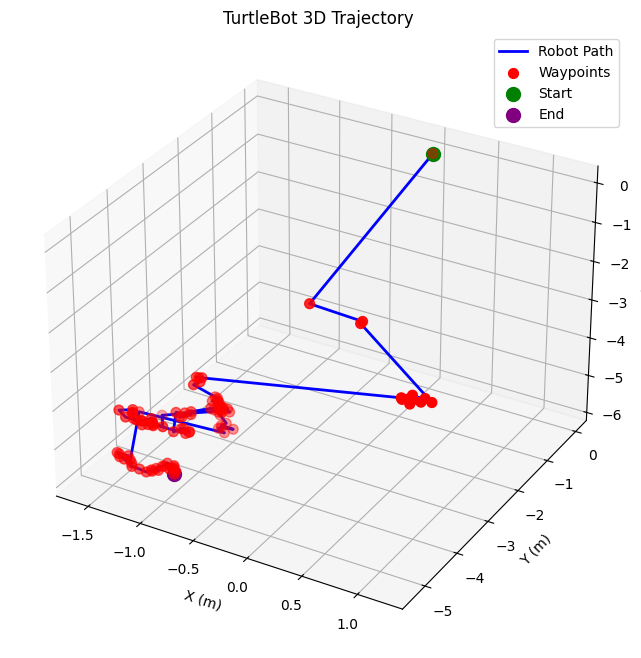

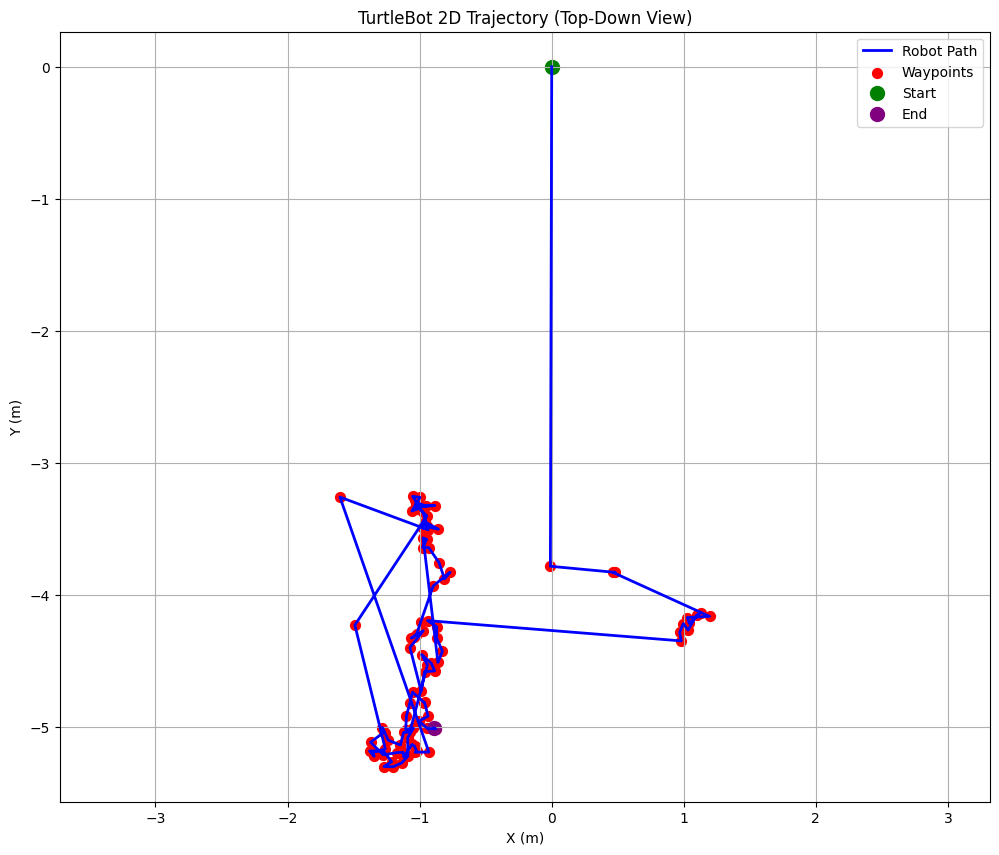

In [16]:
import numpy as np
import open3d as o3d
import copy
import os
from scipy.stats import ortho_group
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# Function to load point clouds
def load_point_cloud(file_path):
    """Load a point cloud from file and preprocess if needed"""
    pcd = o3d.io.read_point_cloud(file_path)
    return pcd

def preprocess_point_cloud(pcd, voxel_size=0.05, estimate_normals=False, knn=30):
    """Preprocess point cloud with optional downsampling and normal estimation"""
    # Create a copy to avoid modifying the original
    processed_pcd = copy.deepcopy(pcd)
    
    # Downsample using voxel grid filter
    processed_pcd = processed_pcd.voxel_down_sample(voxel_size)
    
    # Estimate normals if requested
    if estimate_normals:
        search_param = o3d.geometry.KDTreeSearchParamKNN(knn=knn)
        processed_pcd.estimate_normals(search_param)
        # Orient normals consistently
        processed_pcd.orient_normals_consistent_tangent_plane(k=knn)
    
    return processed_pcd

def point_to_point_icp(source, target, initial_transform=None, 
                       max_iteration=30, threshold=0.02, 
                       estimate_normals=False, knn=30):
    """Run point-to-point ICP with the provided parameters"""
    # Process point clouds if needed
    if estimate_normals:
        source_processed = preprocess_point_cloud(source, voxel_size=0.05, estimate_normals=True, knn=knn)
        target_processed = preprocess_point_cloud(target, voxel_size=0.05, estimate_normals=True, knn=knn)
    else:
        source_processed, target_processed = source, target
    
    # Default initial transform if not provided
    if initial_transform is None:
        # Using scipy's ortho_group to generate a random orthonormal matrix for rotation
        R = ortho_group.rvs(3)
        t = np.random.rand(3, 1) * 0.1  # Small random translation
        
        initial_transform = np.eye(4)
        initial_transform[:3, :3] = R
        initial_transform[:3, 3:] = t
    
    # Evaluate initial alignment
    evaluation = o3d.pipelines.registration.evaluate_registration(
        source_processed, target_processed, threshold, initial_transform)
    initial_fitness = evaluation.fitness
    initial_rmse = evaluation.inlier_rmse
    
    # Run ICP
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source_processed, target_processed, threshold, initial_transform,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=max_iteration))
    
    # Get results
    transformation = reg_p2p.transformation
    fitness = reg_p2p.fitness
    inlier_rmse = reg_p2p.inlier_rmse
    
    return transformation, initial_fitness, initial_rmse, fitness, inlier_rmse

def register_all_point_clouds(dataset_dir, pcd_files, threshold=0.01, max_iteration=100, estimate_normals=True, knn=30):
    """
    Register all point clouds in the sequence and compute the trajectory
    
    Args:
        dataset_dir: Directory containing point cloud files
        pcd_files: List of point cloud filenames
        threshold: Distance threshold for ICP
        max_iteration: Maximum number of ICP iterations
        estimate_normals: Whether to estimate normals for registration
        knn: Number of nearest neighbors for normal estimation
        
    Returns:
        registered_pcds: List of registered point clouds
        trajectory: List of transformation matrices representing the trajectory
        registration_results: DataFrame with registration metrics
    """
    # Lists to store results
    trajectory = []  # To store poses (transformation matrices)
    registered_pcds = []  # To store registered point clouds
    registration_metrics = []  # To store registration metrics
    
    # Load the first point cloud
    first_pcd = load_point_cloud(os.path.join(dataset_dir, pcd_files[0]))
    
    # Add the first point cloud to the registered list
    registered_pcds.append(copy.deepcopy(first_pcd))
    
    # Add the identity matrix as the first pose (global frame = first point cloud)
    global_transform = np.eye(4)
    trajectory.append(global_transform)
    
    # Process each consecutive pair of point clouds
    for i in range(1, len(pcd_files)):
        print(f"\nProcessing point clouds {i-1} and {i}...")
        
        # Load the current point cloud
        current_pcd = load_point_cloud(os.path.join(dataset_dir, pcd_files[i]))
        
        # Previous registered point cloud
        prev_pcd = load_point_cloud(os.path.join(dataset_dir, pcd_files[i-1]))
        
        # Run ICP to find the transformation from current to previous
        transformation, initial_fitness, initial_rmse, final_fitness, final_rmse = point_to_point_icp(
            current_pcd, prev_pcd, 
            initial_transform=None,  # Use random initialization
            max_iteration=max_iteration, 
            threshold=threshold,
            estimate_normals=estimate_normals,
            knn=knn
        )
        
        # Inverse the transformation because we want prev -> current (not current -> prev)
        # This gives us the motion of the robot
        relative_transform = np.linalg.inv(transformation)
        
        # Update the global transformation
        global_transform = global_transform @ relative_transform
        
        # Store the global transformation in the trajectory
        trajectory.append(copy.deepcopy(global_transform))
        
        # Transform the current point cloud to the global frame
        transformed_pcd = copy.deepcopy(current_pcd)
        transformed_pcd.transform(global_transform)
        
        # Add the transformed point cloud to the list
        registered_pcds.append(transformed_pcd)
        
        # Store registration metrics
        registration_metrics.append({
            'pair': f"{i-1}-{i}",
            'source': pcd_files[i],
            'target': pcd_files[i-1],
            'initial_fitness': initial_fitness,
            'initial_rmse': initial_rmse,
            'final_fitness': final_fitness,
            'final_rmse': final_rmse,
            'improvement_fitness': final_fitness - initial_fitness,
            'improvement_rmse': initial_rmse - final_rmse
        })
        
        print(f"Registration {i}/{len(pcd_files)-1} - Fitness: {final_fitness:.6f}, RMSE: {final_rmse:.6f}")
    
    # Convert metrics to DataFrame
    metrics_df = pd.DataFrame(registration_metrics)
    
    return registered_pcds, trajectory, metrics_df

def save_trajectory_to_csv(trajectory, output_path):
    """
    Save the trajectory to a CSV file
    
    Args:
        trajectory: List of transformation matrices
        output_path: Path to save the CSV file
    """
    # Extract positions (translations) from transformation matrices
    positions = []
    for transform in trajectory:
        # Extract X, Y, Z coordinates
        x, y, z = transform[:3, 3]
        
        # Extract rotation matrix
        rotation = transform[:3, :3]
        
        # Convert rotation to Euler angles (roll, pitch, yaw) - ZYX convention
        # This is a simplified version - for precise conversion, consider using scipy.spatial.transform
        yaw = np.arctan2(rotation[1, 0], rotation[0, 0])
        pitch = np.arctan2(-rotation[2, 0], np.sqrt(rotation[2, 1]**2 + rotation[2, 2]**2))
        roll = np.arctan2(rotation[2, 1], rotation[2, 2])
        
        # Convert to degrees
        roll_deg, pitch_deg, yaw_deg = np.degrees(roll), np.degrees(pitch), np.degrees(yaw)
        
        positions.append({
            'x': x,
            'y': y,
            'z': z,
            'roll': roll_deg,
            'pitch': pitch_deg,
            'yaw': yaw_deg
        })
    
    # Create DataFrame and save to CSV
    trajectory_df = pd.DataFrame(positions)
    trajectory_df.to_csv(output_path, index_label='frame')
    
    return trajectory_df

def plot_trajectory_3d(trajectory_df):
    """
    Plot the 3D trajectory
    
    Args:
        trajectory_df: DataFrame with trajectory positions
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot trajectory
    ax.plot(trajectory_df['x'], trajectory_df['y'], trajectory_df['z'], 'b-', linewidth=2, label='Robot Path')
    ax.scatter(trajectory_df['x'], trajectory_df['y'], trajectory_df['z'], c='red', s=50, label='Waypoints')
    
    # Mark start and end
    ax.scatter(trajectory_df['x'].iloc[0], trajectory_df['y'].iloc[0], trajectory_df['z'].iloc[0], 
               c='green', s=100, label='Start')
    ax.scatter(trajectory_df['x'].iloc[-1], trajectory_df['y'].iloc[-1], trajectory_df['z'].iloc[-1], 
               c='purple', s=100, label='End')
    
    # Set labels and title
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('TurtleBot 3D Trajectory')
    ax.legend()
    
    # Save the plot
    plt.savefig('turtlebot_trajectory_3d.png', dpi=300, bbox_inches='tight')
    
    # Return figure for further modifications if needed
    return fig, ax

def plot_trajectory_2d(trajectory_df):
    """
    Plot the 2D trajectory projection (top-down view)
    
    Args:
        trajectory_df: DataFrame with trajectory positions
    """
    plt.figure(figsize=(12, 10))
    
    # Plot trajectory
    plt.plot(trajectory_df['x'], trajectory_df['y'], 'b-', linewidth=2, label='Robot Path')
    plt.scatter(trajectory_df['x'], trajectory_df['y'], c='red', s=50, label='Waypoints')
    
    # Mark start and end
    plt.scatter(trajectory_df['x'].iloc[0], trajectory_df['y'].iloc[0], c='green', s=100, label='Start')
    plt.scatter(trajectory_df['x'].iloc[-1], trajectory_df['y'].iloc[-1], c='purple', s=100, label='End')
    
    # Set labels, title, and grid
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('TurtleBot 2D Trajectory (Top-Down View)')
    plt.grid(True)
    plt.axis('equal')  # Equal aspect ratio
    plt.legend()
    
    # Save the plot
    plt.savefig('turtlebot_trajectory_2d.png', dpi=300, bbox_inches='tight')
    
def visualize_combined_point_cloud(registered_pcds, trajectory=None, downsample_voxel_size=0.05):
    """
    Visualize the combined registered point cloud with the trajectory
    
    Args:
        registered_pcds: List of registered point clouds
        trajectory: List of transformation matrices for trajectory visualization
        downsample_voxel_size: Size for downsampling to reduce visualization load
    """
    # Create a combined point cloud map with random colors for each original cloud
    map_vis = []
    
    # Process and add each registered point cloud
    for i, pcd in enumerate(registered_pcds):
        # Downsample the point cloud for visualization
        pcd_down = pcd.voxel_down_sample(voxel_size=downsample_voxel_size)
        pcd_colored = copy.deepcopy(pcd_down)
        
        # Assign a random color to each point cloud, but keep colors distinct
        # Use HSV color space for better visual distinction
        hue = i / len(registered_pcds)  # Evenly distributed hue values
        # Convert HSV to RGB (simplified conversion)
        if hue < 1/6:
            r, g, b = 1, 6*hue, 0
        elif hue < 2/6:
            r, g, b = 2-6*hue, 1, 0
        elif hue < 3/6:
            r, g, b = 0, 1, 6*hue-2
        elif hue < 4/6:
            r, g, b = 0, 4-6*hue, 1
        elif hue < 5/6:
            r, g, b = 6*hue-4, 0, 1
        else:
            r, g, b = 1, 0, 6-6*hue
        
        pcd_colored.paint_uniform_color([r, g, b])
        map_vis.append(pcd_colored)
    
    # Add trajectory visualization if provided
    if trajectory is not None:
        # Create a LineSet to represent the trajectory
        line_set = o3d.geometry.LineSet()
        
        # Extract the translation part of each transformation matrix
        points = np.array([T[:3, 3] for T in trajectory])
        
        # Set the points
        line_set.points = o3d.utility.Vector3dVector(points)
        
        # Create lines connecting consecutive points
        lines = [[i, i + 1] for i in range(len(points) - 1)]
        line_set.lines = o3d.utility.Vector2iVector(lines)
        
        # Set colors (red)
        colors = [[1, 0, 0] for _ in range(len(lines))]
        line_set.colors = o3d.utility.Vector3dVector(colors)
        
        map_vis.append(line_set)
        
        # Add coordinate frames at key positions along trajectory
        step = max(1, len(trajectory) // 10)  # Show ~10 frames
        for i in range(0, len(trajectory), step):
            coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
                size=0.3, origin=[0, 0, 0])
            coord_frame.transform(trajectory[i])
            map_vis.append(coord_frame)
    
    # Visualize
    o3d.visualization.draw_geometries(map_vis)
    
    # Create and save a combined point cloud
    combined_pcd = o3d.geometry.PointCloud()
    for pcd in registered_pcds:
        combined_pcd += pcd.voxel_down_sample(voxel_size=downsample_voxel_size)
    
    # Save the combined point cloud
    o3d.io.write_point_cloud("global_registered_pointcloud.pcd", combined_pcd)
    print("Saved global registered point cloud to 'global_registered_pointcloud.pcd'")

def main():
    # Set the dataset directory path
    dataset_dir = "C:/Users/aarya/Github_Projects/Striver_A2Z/cv_bonus/selected_pcds"  # Change this to your dataset path
    
    # Get sorted list of point cloud files
    pcd_files = sorted([f for f in os.listdir(dataset_dir) if f.startswith("pointcloud_") and f.endswith(".pcd")])
    
    print(f"Found {len(pcd_files)} point cloud files.")
    
    # Best hyperparameters found from previous experiments
    threshold = 0.01
    max_iteration = 100
    estimate_normals = True
    knn = 30
    
    print("\nRegistering all point clouds with the following parameters:")
    print(f"- Distance threshold: {threshold}")
    print(f"- Max iterations: {max_iteration}")
    print(f"- Using normal estimation: {estimate_normals}")
    print(f"- KNN for normals: {knn}")
    
    # Register all point clouds and compute trajectory
    registered_pcds, trajectory, metrics_df = register_all_point_clouds(
        dataset_dir, pcd_files, threshold, max_iteration, estimate_normals, knn)
    
    print("\nRegistration complete!")
    print(f"Registered {len(registered_pcds)} point clouds.")
    print(f"Trajectory has {len(trajectory)} poses.")
    
    # Save registration metrics
    metrics_df.to_csv("registration_metrics.csv", index=False)
    print("Saved registration metrics to 'registration_metrics.csv'")
    
    # Save trajectory to CSV
    trajectory_df = save_trajectory_to_csv(trajectory, "turtlebot_trajectory.csv")
    print("Saved trajectory to 'turtlebot_trajectory.csv'")
    
    # Plot the trajectory
    plot_trajectory_3d(trajectory_df)
    plot_trajectory_2d(trajectory_df)
    print("Created trajectory plots: 'turtlebot_trajectory_3d.png' and 'turtlebot_trajectory_2d.png'")
    
    # Visualize the global registered point cloud and trajectory
    print("\nVisualizing the registered point cloud map and trajectory...")
    visualize_combined_point_cloud(registered_pcds, trajectory, downsample_voxel_size=0.05)
    
    print("\nSummary of Registration Results:")
    print(f"Average final fitness: {metrics_df['final_fitness'].mean():.4f}")
    print(f"Average final RMSE: {metrics_df['final_rmse'].mean():.4f}")
    print(f"Total trajectory distance: {np.sum(np.sqrt(np.diff(trajectory_df['x'])**2 + np.diff(trajectory_df['y'])**2 + np.diff(trajectory_df['z'])**2)):.4f} meters")
    
    # Save a summary report
    with open("registration_summary.txt", "w") as f:
        f.write("Point Cloud Registration Summary\n")
        f.write("==============================\n\n")
        f.write(f"Number of point clouds processed: {len(pcd_files)}\n")
        f.write(f"Best hyperparameters used:\n")
        f.write(f"- Distance threshold: {threshold}\n")
        f.write(f"- Max iterations: {max_iteration}\n")
        f.write(f"- Using normal estimation: {estimate_normals}\n")
        f.write(f"- KNN for normals: {knn}\n\n")
        f.write(f"Registration Results:\n")
        f.write(f"- Average fitness: {metrics_df['final_fitness'].mean():.4f}\n")
        f.write(f"- Average RMSE: {metrics_df['final_rmse'].mean():.4f}\n")
        f.write(f"- Average fitness improvement: {metrics_df['improvement_fitness'].mean():.4f}\n")
        f.write(f"- Average RMSE improvement: {metrics_df['improvement_rmse'].mean():.4f}\n\n")
        f.write(f"Trajectory Information:\n")
        f.write(f"- Total distance traveled: {np.sum(np.sqrt(np.diff(trajectory_df['x'])**2 + np.diff(trajectory_df['y'])**2 + np.diff(trajectory_df['z'])**2)):.4f} meters\n")
        f.write(f"- Bounding box (X): {trajectory_df['x'].min():.2f} to {trajectory_df['x'].max():.2f} meters\n")
        f.write(f"- Bounding box (Y): {trajectory_df['y'].min():.2f} to {trajectory_df['y'].max():.2f} meters\n")
        f.write(f"- Bounding box (Z): {trajectory_df['z'].min():.2f} to {trajectory_df['z'].max():.2f} meters\n")
    
    print("\nSaved summary report to 'registration_summary.txt'")
    print("\nAll tasks completed successfully!")

if __name__ == "__main__":
    main()